## Building a Book Recommender using the Bookcrossing$^{[1]}$ dataset

### Part 1: Setup

First we grab the datasets as csv and load into the work space. 

In [662]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from wordcloud import WordCloud, STOPWORDS
from IPython.display import Image
from IPython.display import display

ratings = pd.read_csv('./BX-CSV-Dump/BX-Book-Ratings.csv', sep=";", error_bad_lines=False, warn_bad_lines=False, engine='python')
users = pd.read_csv('./BX-CSV-Dump/BX-Users.csv', sep=";", error_bad_lines=False, warn_bad_lines=False, engine='python')
books = pd.read_csv('./BX-CSV-Dump/BX-Books.csv', sep=";", error_bad_lines=False, warn_bad_lines=False, engine='python')

ratings.columns = ["userID","ISBN","BookRating"]
users.columns= ["userID","Location","Age"]
books.columns= ["ISBN","BookTitle","BookAuthor","YearOfPublication","Publisher","ImageURLS","ImageURLM","ImageURLL"]


There are three datasets, in total contains 278177 users, 1149766 ratings of both explicit(scale of 1 to 10) and implicit (score of 0), and 270491 books.

The ratings data contains three colmuns: userID, ISBN, BookRating. 
The books data contains eight columns, what we interested the most and will be using later are: ISBN code of the book, Book Title,Year of publication, and the imageURL's that we are later going to that to load the book page.
The users data contains three columns: userID, Location and Age. 

In [669]:
ratings.head()[:3]

,userID,ISBN,BookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


In [670]:
books.head()[:3]

,ISBN,BookTitle,BookAuthor,YearOfPublication,Publisher,ImageURLS,ImageURLM,ImageURLL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


In [671]:
users.head()[:3]

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN


We would like to also the ISBN code at this point, since by sampling the books data there is some messy encodings.

Since in order to look up one specific book, we need to translate from the ISBN to the book page by:

'https://www.amazon.com/dp/' + ISBN + '/'

Else if we only interested in the book name, we can use the ISBN to get the books.BookTitle.

In [103]:
ratings.ISBN=ratings.ISBN.str.replace(r'[^\w\d]+', '')
books.ISBN=books.ISBN.str.replace(r'[^\w\d]+', '')

### Part 2: Basic Descriptive analysis

Here we will visualize some basic information about the dataset and describe some interesting patterns.

Some questions we may ask are:
    
    What is the distribution of ratings per user?
    What is the distribution of ratings per item?
    How "sparse" is the ratings matrix? (no viz needed)
    What is the overall mean rating? (no viz needed)
    How many times is each rating value used?

For the section, since there are many implicit ratings that would not bring much insight to the overall explicit score distribution, we can only look for the explicit ratings from the users. Thus we drop the '0' ratings here and leave only scores from 1 to 10.

In [673]:
explicit_rating = ratings[ratings.BookRating !=0]
explicit_rating.sample(3)

,userID,ISBN,BookRating
500257,120828,0345412923,8
593624,143175,0970760094,7
273635,63717,0006374921,10


Let us first look at what is the distribution of ratings per user?

We group our data by the userID and see how many times a user rate a score on average. From the graph we can see that the user rates 8 the most often, follow by 7, 9, 6 and 10. Scores below 5 are uncommon.

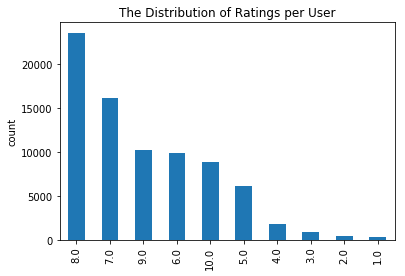

In [698]:
explicit_rating.groupby('userID').BookRating.mean().round().value_counts().plot(kind='bar', title='The Distribution of Ratings per User').set_ylabel('count')
plt.show()

Then we can see how is the distribution of ratings per book. For this task, we group by book's unique ISBN code instead. From the graph below, we notice still, that for the explicit scores most books receive 8, and follow by 7, 10 and 9. There are about the same number of 5 and 6, and again scores below 5 are quite rare.

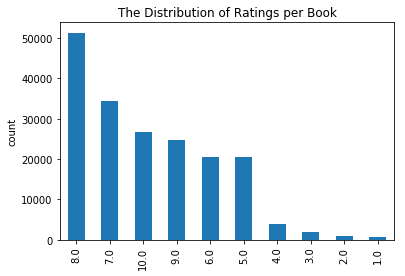

In [699]:
explicit_rating.groupby('ISBN').BookRating.mean().round().value_counts().plot(kind='bar', title='The Distribution of Ratings per Book').set_ylabel('count')
plt.show()

To calculate the sparsity, since there are no 'na' items in our data, instead we look at how many implicit ratings are there compare to the overall ratings size. And we found that the sparsity is about 62%.

In [700]:
(len(ratings.BookRating) - len(explicit_rating.BookRating))/ len(ratings.BookRating) 

0.6228284711845715

For the overall mean rating, if we only look at the frequence of each explicit rating is about 7.6. Per book the overall average is 7.49, and per user is 7.46. 

If we also take the implicit ratings into consideration, the overall mean is 2.86, with per book's mean of 2.94, and per user's mean as 4.39.

In [709]:
print(explicit_rating.BookRating.mean())
print(explicit_rating.groupby('ISBN')['BookRating'].mean().round().mean())
print(explicit_rating.groupby('userID')['BookRating'].mean().round().mean())

print(ratings.BookRating.mean())
print(ratings.groupby('ISBN')['BookRating'].mean().round().mean())
ratings.groupby('userID')['BookRating'].mean().round().mean()

7.601066736767829
7.492544215784861
7.460596166947312
2.8669059617348225
2.940524747096566


4.393449474704106

For how many times is each rating value used, we simply do a frequency count of each rating scores. Due to the sparsity of the data, we see that there are above 70000 implicit ratings. Rating score of 8 is above 10,000, following by 10, 7, and 9 slightly below that.

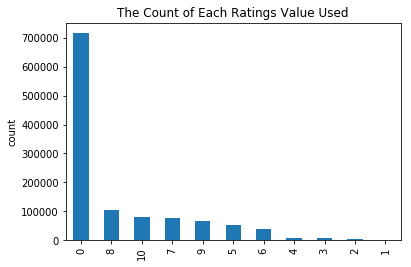

In [85]:
ratings.BookRating.value_counts().plot(kind='bar', title='The Count of Each Ratings Value Used').set_ylabel('count')
plt.show()

### Part 3: Finding outliers

First we want to show the five most often rated books in the raw data. We will create a new data frame to store the ratings and the counts. The we will show the top five most rated books' cover below, in the order of the number of ratings they have.

In [155]:
rating_count=pd.DataFrame(ratings.groupby('ISBN',as_index=False)['BookRating'].count())
avg_rating=pd.DataFrame(ratings.groupby('ISBN',as_index=False)['BookRating'].mean())
avg_rating_count=avg_rating.merge(rating_count, on='ISBN',how="inner")
avg_rating_count.columns=["ISBN","avg_rating","ratings_count"]

In [720]:
avg_rating_count=avg_rating_count.sort_values('ratings_count', ascending=False)
most_rated = books.loc[books.ISBN.isin(list(avg_rating_count.head()['ISBN']))]
#most_rated.BookTitle
covers=[Image(url=most_rated.iloc[k].ImageURLL) for k in range(5)]
display(*covers)

We are also interested in the five most highly rated books, and five books with the lowest ratings. In order to not overly favor books with only few ratings, I will use a "robust" average methodology that we add some number of average rating to every book item.

We first calculate the 'robust mean', which the overall mean ratings group by books, then we decide the 'robust rating number' to be 50. Ao we are adding 50 mean ratings to every book in our dataset.


In [721]:
robust_mean = ratings.groupby('ISBN').BookRating.mean().round().mean()
robust_rating_num = 50
avg_rating_count['robsut'] = avg_rating_count['avg_rating'] * avg_rating_count['ratings_count'] + (robust_mean * robust_rating_num)
avg_rating_count['robsut_rating'] = avg_rating_count['robsut'] / (avg_rating_count['ratings_count'] + robust_rating_num)

avg_rating_count.head()[:3]

,ISBN,avg_rating,ratings_count,robsut,robsut_rating
247146,0971880107,1.019584,2502,2698.026237,1.057220
47132,0316666343,4.468726,1295,5934.026237,4.411915
83115,0385504209,4.651584,884,4259.026237,4.559985


And now we can sort by the robust mean ratings, and find the five most highly rated books:

In [723]:
robust_rating = avg_rating_count.sort_values('robsut_rating', ascending=False)
robust_most_rated = books.loc[books.ISBN.isin(list(robust_rating.head()['ISBN']))]
#robust_most_rated.BookTitle
covers=[Image(url=robust_most_rated.iloc[k].ImageURLL) for k in range(5)]
display(*covers)

And five least favored books by our readers:

In [724]:
robust_rating_lo = avg_rating_count.sort_values('robsut_rating', ascending=True)
robust_least_rated = books.loc[books.ISBN.isin(list(robust_rating_lo.head()['ISBN']))]
#robust_least_rated.BookTitle
covers=[Image(url=robust_least_rated.iloc[k].ImageURLL) for k in range(5)]
display(*covers)

### Part 4: Rating overlap


We are then interested in a reasonably controversial popular book A. To pick that, we can use the standard deviation, since the higher the sd, the more 'varied' are there among your data. In our case, a controversial popular book might be that it receives many high ratings, but also many low ratings.

To do that, we first want to calculate the standard deviation of the list of ratings for each book. So we group by the ISBN code and apply the 'std' function built in numpy to calculate the sd of ratings per book. Then we find the maxium sd, which is 4.5. We found that there are 14 books with the highest sd(probably due to the rounding precision).

In [728]:
explicit_rating['sd'] = explicit_rating.groupby('ISBN', as_index=False)['BookRating'].apply(np.std)
s = np.max(explicit_rating.sd)
highest_sd_idx = (np.where(np.array(explicit_rating.sd) == np.array(np.max(explicit_rating.sd))))
highest_sd_idx

# print(highest_sd_idx)
# for i in highest_sd_idx[0]:
#     print(explicit_rating[i:i+1])

/Users/qinxi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(array([ 3325,  3549,  4654,  6141, 10139, 14159, 14572, 14883, 18465,
        18728, 25616, 26893, 33655, 53600]),)

Then we choose the book with the most ratings, which has the ISBN of 22585. We find that particular book is:

In [323]:
contro_id = 22585
book = books.loc[books.ISBN.isin(explicit_rating[contro_id:contro_id+1]['ISBN'])]
covers=[Image(url=book.iloc[0].ImageURLL)]
display(*covers)

Then we want to calculate the 20 most commonly corated books to the controverisal book we just identified above, Wifey. To do this, we want to find the books with the highest number of users who have rated both the book, and Wifey. 

First we start by getting all the users who rated Wifey. Then we gab all the books that these users have ever rated. Then we will count how many users under each of these books also rated Wifey. And we will sort by the overlap of the users and give our top 20 most corated book list. Which are:

(I will not display the books like above due to the length of the list, but feel free to uncomment the code and check them out.)

In [785]:
contro_rater = ratings.loc[ratings.ISBN.isin(explicit_rating[22585:22585+1]['ISBN'])]
len(set(contro_rater.userID)) #number of users who rated that book
rated_contro_all = ratings.loc[ratings.userID.isin(contro_rater.userID)]
corated = pd.DataFrame(rated_contro_all.groupby('ISBN', as_index=False)['userID'].count())
corated.columns=["ISBN","IDcounts"]

top_20_corated = corated.sort_values('IDcounts', ascending=False)[1:22] #the OTHER 20 top corated books, not including itself
corated_list = top_20_corated.merge(books, on='ISBN', how="inner")

list(corated_list.BookTitle)
# covers=[Image(url=corated_list.iloc[k].ImageURLL) for k in range(20)]
# display(*covers)

['The Lovely Bones: A Novel',
 'Summer Sisters',
 'Divine Secrets of the Ya-Ya Sisterhood: A Novel',
 'Wild Animus',
 'Smart Women',
 'A Time to Kill',
 "Where the Heart Is (Oprah's Book Club (Paperback))",
 'Interview with the Vampire',
 'The Notebook',
 'The Red Tent (Bestselling Backlist)',
 'House of Sand and Fog',
 'The Firm',
 'The Horse Whisperer',
 'The Da Vinci Code',
 "The Pilot's Wife : A Novel",
 'Confessions of a Shopaholic (Summer Display Opportunity)',
 'Snow Falling on Cedars',
 "She's Come Undone (Oprah's Book Club (Paperback))",
 'The Chamber',
 'The Partner']

Looking at these books, I kind of see some similarity in the genre. It's not surprising that some of the books in the corated list share the same author. Some of the topics in the corated list focused on women, romance/sexuality and psychology. Some books appear because they are already the most rated books, and a great amount of users read them and rated them. 


### Part 5: Similarity 

#### Calculate correlations

From the list above, we want choose a pair (A,B) items that we think will be positively correlated, and another pair (A,C) that will be less positively correlated. 

A is our identified controversial book, titled 'Wife', which is a book about housewife, affairs, and open marriages according to wikipedia. For B I will go with the book 'Summer Sisters' on the least, as it's from the same author, and ranked high in the corated list. For book C I will choose 'The Chamber' on the list, which is a legal thriller book, and does not seem to share much similarity with our book A.


    A = Wifey  ISBN   0671693816
    B = Summer Sisters (same author)  ISBN   0440226430
    C = The Chamber (legal thriller) ISBN   0440220602



We grab all the ratings for the users from these books, and convert them into numpy arrays. Then we will call the cosine similarity to compare our A and B book, and A and C.

In [216]:
from math import sqrt

def cosine(X, Y): 
    return np.sum(X * Y) / (sqrt(np.sum(X ** 2)) *sqrt(np.sum(Y ** 2)))

In [494]:
user_id_count = top_20_corated.merge(contro_rater, on='ISBN', how='outer')
ratingsA = np.array(contro_rater.BookRating[:100])
ratingsB = np.array(rated_contro_all[rated_contro_all['ISBN']=='0440226430'].BookRating)
ratingsC = np.array(rated_contro_all[rated_contro_all['ISBN']=='0440220602'].BookRating)

The correlation between Wifey(A) and Summer Sisters(B) is about 0.40.

In [734]:
cosine(ratingsA[:len(ratingsB)], ratingsB)

0.39877787874957887

The correlation between Wifey(A) and The Chamber(C) is about 0.20.

In [735]:
cosine(ratingsA[:len(ratingsC)], ratingsC)

0.20434952251735539

In terms of the time complexity of our method, we have 
    u : the number of users, 
    m: the number of items, 
    n: the total number of ratings,  
    b: the number of users who have rated both A and B. 

Since we are mostly doing the operation on the array of user ratings, and math operations like sum or sqrt should be like O(1) cheap in numpy on each element. So the overall time complexity of our method would be O(b) for each pair comparison, where the bottle neck actually happens at searching for the book with the specific ISBN and select the corresponding user, which is a linear look up process.   
   




#### Simultaneously calculate correlations with A and all other items:
Now that you've calculated correlations for pairs of items, consider how you can generalize the work you're doing in to simultaneously tally the three terms for all items (paired with A).
You should only calculate correlations for items with some minimum threshold of coratings. Pick a threshold that seems reasonable to you.

Now if we want to generalize the process of calculating the correlation between other books paired with A. We set a corating threshold to be 20, which means that we only want to compare books that share at least 20 same user who rated both the book and A with A. 

We defined a function called cal_correlation that takes corating_threshold as the only input. It will grab the list of ratings of the 20 users who have rated both the book and A. Then for each of the books that match with our cateria, we call cosine function to compare the pair of such pairs, and append the correlation score in the resul list.

In [787]:
top_corated = corated.sort_values('IDcounts', ascending=False)[1:]
corating_threshold = 20

def cal_correlation(corating_threshold): 
    corr_res = []
    isbn_list = top_corated[top_corated['IDcounts'] >= corating_threshold].ISBN
    for isbn in isbn_list:
        ratings_i = np.array(rated_contro_all[rated_contro_all['ISBN'] == isbn].BookRating)
        corr_res.append(cosine(ratingsA[:len(ratings_i)], ratings_i))
    return corr_res
    
print(cal_correlation(corating_threshold))

[0.65098490524609709, 0.39877787874957887, 0.37039376575783245, 0.02694722863621233, 0.28223915343829709, 0.19692710868428806, 0.45348362022763206, 0.46686781774321273, 0.46879156841105896, 0.30799107607869869, 0.49823008294130861, 0.41677393914581412, 0.13277408402242333, 0.41634758911455644, 0.33278387594945497, 0.40054039115236911, 0.35686533793801223, 0.29025756607024578, 0.50795074062293011, 0.20434952251735539, 0.23322710065907223, 0.12721562869323952, 0.29304148232478328, 0.49935452594132262, 0.14950771831724541]


I would say the tricky about this step of generalization is actually the choice of co-rater threshold. I tried 15 in the first place, but the resulting data was too large for the jupyter to process since I intend to store each of the correlation in a list. After I changed the threshold to 20 the method works smoothly. 

The top 10 items are:
    1. The Lovely Bones: A Novel, with 0.65 correlation.
    2. Summer Sisters, with 0.40 correlation
    3. Divine Secrets of the Ya-Ya Sisterhood: A Novel,  with 0.37 correlation
    4. Wild Animus,  with 0.03 correlation
    5. Smart Women,  with 0.28 correlation
    6. A Time to Kill,  with 0.20 correlation
    7. Where the Heart Is (Oprah's Book Club,  with 0.45 correlation
    8. Interview with the Vampire,  with 0.31 correlation
    9. The Notebook,  with 0.47 correlation
    10. The Red Tent (Bestselling Backlist),  with 0.47 correlation


In the first I thought it is quite surpring that we see book with 0.03 correlation on the list, but then I realize that book is the most rated book across our dataset thus it's not too surprised to see there are many users who rated Wifey also rated the popular book. It's also interesting that some books by the same author on the list, such as Summer Sisters and Smart Women, actually have a lower correlation to the book then books like The Notebook, The Red Tent, or even Interview with the Vampire. (Maybe it is somehow similar, I never read these books).

In terms of the time complexity of our method, we have: 
    
    u: the number of users, 
    m: the number of items, 
    n: the total number of ratings,  
    b: the number of users who have rated both A and B. 

Since we already discussed that the time complextity for calculating a single pair is O(b), an and here we are looping through m books who has b ratings each, the complexity should now be O(mb). 


### Part 6: Build our recommender for the book!

In [521]:
from sklearn.neighbors import NearestNeighbors
import scipy

After calculating the similarity, I am curious about how would that apply to be used for actual book-to-book recommendation. Inspired by the KNN classifier mentioned in class, I wonder what if we use the cosine similarity to find the nearest neighbors, in our case would be the most correlated books that we can push up for the recommender.

Still based off our book A, Wifey, we first merge all the users who rated that book with all the books. Then we can pivot the dataframe, and have the BookTitle as the index(the very first column), and each individual userID as the column, with the entries as the user's ratings for the book in the row. After we use spcipy's sparse matrix to store all the ratings in that format.

Then we use the NearestNeighbors library from sklearn. We choose cosine as the metric for measuring the distance, and fit our model around the matrix we just build.

In [738]:
A_user_books = rated_contro_all.merge(books, on='ISBN', how='outer')
A_user_rating_pivot = A_user_rating.pivot(index = 'BookTitle', columns = 'userID', values ='BookRating').fillna(0)
A_user_rating_matrix = scipy.sparse.csr_matrix(A_user_rating_pivot.values)

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(A_user_rating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

Now we can build our recommender! 

We will write a function called book_recommend, which takes a  book index and number of neighbors. I will only show the recommendation result for the Wifey book, but you can feed in any book index you want, and I will use 6 closest neighbors for the top five recommendatons. 

In [802]:
A_index = int(np.where(A_user_rating_pivot.index == "Wifey")[0])

def book_recommend(A_index, neighbor):
    res = []
    distances, indices = model_knn.kneighbors(A_user_rating_pivot.iloc[A_index, :].values.reshape(1, -1), n_neighbors = neighbor)
    for i in range(0, len(distances.flatten())):
        if i == 0:
            res.append(A_user_rating_pivot.index[A_index])
        else:
            res.append((A_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))
    return res

res = book_recommend(A_index, 6)
print('\t People like ' + res[0] + ' may also like:')
for k in range(1, 6):
    print('\t   ', res[k][0], '   dist=', res[k][1])

	 People like Wifey may also like:
	    Summer Sisters    dist= 0.618288600413
	    Smart Women    dist= 0.619429640648
	    Accident    dist= 0.642762820169
	    Wanderlust    dist= 0.659682101458
	    If There Be Thorns (Dollanganger)    dist= 0.66039221976


We can see the top recommendation is actually the two books by the same author that we saw in the previous top corated list - that make sense and very promising! I cannot comment much about the rest, but the genre looks similar, and we do notice that the distance between the later three canadaties isn't that big of a gap. Very fond of seeing it working though, also tested on some other books and the result seems pretty reasonable.

$^{[1]}$ Acknowledgement for using the dataset: 

    Improving Recommendation Lists Through Topic Diversification,
    Cai-Nicolas Ziegler, Sean M. McNee, Joseph A. Konstan, Georg Lausen; Proceedings of the 14th International World Wide Web Conference (WWW '05), May 10-14, 2005, Chiba, Japan. 
